In [43]:
using Gen
using PyPlot
using PyCall

In [46]:
py"""
#environment.close()

from IPython.display import HTML
import yaml
from animalai.envs.arena_config import ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException
import random
import copy
import numpy as np
import math
from collections import defaultdict

conf_file = '/Users/aidancurtis/AnimalAI-Olympics/examples/configurations/curriculum/0.yml'
yaml_data = yaml.load(open(conf_file, "r"), Loader=yaml.Loader)

# random position
yaml_data.arenas[-1].items[0].positions[0].z = 10
# print(yaml_data.arenas[-1].items[0].positions[0].y)
# print(yaml_data.arenas[-1].items[0].positions[0].z)
goal_pose = (random.uniform(0, 40), 0, random.uniform(0, 40), 0)

yaml_data.arenas[-1].items[1].positions[0].x = goal_pose[0]
yaml_data.arenas[-1].items[1].positions[0].y = goal_pose[1]
yaml_data.arenas[-1].items[1].positions[0].z = goal_pose[2]


x=yaml_data.arenas[-1].items[0].positions[0].x
y=yaml_data.arenas[-1].items[0].positions[0].y
z=yaml_data.arenas[-1].items[0].positions[0].z
r = yaml_data.arenas[-1].items[0].rotations[0]

ACTIONS = [[1, 0],
          [1, 1], 
          [1, 2]]

framerate = 60
 
agent_start_pose = (x, y, z, r)
print(goal_pose)


def new_pose(start_pose, vel):
    return list((start_pose[i]+vel[i] for i in range(4)))

def set_pose(data, pose):
    cp_yaml_data = copy.deepcopy(data)
    cp_yaml_data.arenas[-1].items[0].positions[0].x = pose[0]
    cp_yaml_data.arenas[-1].items[0].positions[0].y = pose[1]
    cp_yaml_data.arenas[-1].items[0].positions[0].z = pose[2]
    cp_yaml_data.arenas[-1].items[0].rotations[0] = pose[3]
    return cp_yaml_data

def set_goal_pose(data, pose):
    cp_yaml_data = copy.deepcopy(data)
    cp_yaml_data.arenas[-1].items[1].positions[0].x = pose[0]
    cp_yaml_data.arenas[-1].items[1].positions[0].y = pose[1]
    cp_yaml_data.arenas[-1].items[1].positions[0].z = pose[2]
    return cp_yaml_data

resolution=64
try:
    environment = AnimalAIEnvironment(
            file_name='/Users/aidancurtis/aaio_mac',
            base_port=5030,
            resolution=resolution,
#             play=True,
            arenas_configurations=yaml_data,

        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

agent_groups = environment.get_agent_groups()
agent_group_spec = environment.get_agent_group_spec(agent_groups[0])
agent_group = agent_groups[0] 

"""



CrashReporter: initialized
Mono path[0] = '/Users/aidancurtis/aaio_mac.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/aidancurtis/aaio_mac.app/Contents/MonoBleedingEdge/etc'


In [47]:
struct ArrayNoiseModel <: Gen.Distribution{Array{Float64, 3}} end
const array_noise_model = ArrayNoiseModel()

function Gen.logpdf(::ArrayNoiseModel,
        x::Array{Float64, 3},
        mu::Array{Float64, 3})
    diffs = (x .- mu)
    return -sum(diffs .^ 2)
end

Gen.has_argument_grads(::ArrayNoiseModel) = (true,)
Gen.has_output_grad(::ArrayNoiseModel) = false

function Gen.logpdf_grad(::ArrayNoiseModel,
        x::Array{Float64, 3},
        mu::Array{Float64, 3})
    diffs = x .- mu
    mu_grad = 2 * diffs
    return (nothing, mu_grad)
end


function Gen.random(::ArrayNoiseModel,
        x::Array{Float64, 3})
    diffs = x
    return diffs
end


struct NoiseModel <: Gen.Distribution{Matrix{Float64}} end
const noise_model = NoiseModel()

function Gen.logpdf(::NoiseModel,
        x::Matrix{Float64},
        mu::Matrix{Float64})
    diffs = (x .- mu)
    return -sum(diffs .^ 2)
end

Gen.has_argument_grads(::NoiseModel) = (true,)
Gen.has_output_grad(::NoiseModel) = false

function Gen.logpdf_grad(::NoiseModel,
        x::Matrix{Float64},
        mu::Matrix{Float64})
    diffs = x .- mu
    mu_grad = 2 * diffs
    return (nothing, mu_grad)
end


In [48]:

@gen function model(T::Int)
    

    xs = Vector{Float64}(undef, T+1)
    zs = Vector{Float64}(undef, T+1)
    gx = Vector{Float64}(undef, T+1)
    gz = Vector{Float64}(undef, T+1)
    rs = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = @trace(uniform(0, 40), :x0)
    gx = @trace(uniform(0, 40), :gx0)
       
    # prior on initial y-coordinate
    z = @trace(uniform(0, 40), :z0)
    gz = @trace(uniform(0, 40), :gz0)
    
    # prior on initial rotation
    r = @trace(uniform(0, 360), :r0)

    # record position
    xs[1] = x
    zs[1] = z
    rs[1] = r
    
    # generate successive states and measurements
    for t=1:T
        # capture observation
        py"""
        def gen_obs(cur_node,goal_node, yaml_data):
            new_yaml_data = set_pose(yaml_data, cur_node)
            new_yaml_data = set_goal_pose(new_yaml_data, goal_node)
            environment.reset(arenas_configurations=new_yaml_data)
            environment.step()
            step_result = environment.get_step_result(agent_group)
            visual_observation = step_result.obs[0]
            return visual_observation
        """
        
        vis = py"gen_obs"([x, 0, z, rs[t]], [gx, 0, gz], py"yaml_data")
        sq_vis = reshape(vis, (size(vis, 2), size(vis, 3), size(vis, 4)) )
        sq_vis_f64 = convert(Array{Float64, 3}, sq_vis)
        @trace(array_noise_model(sq_vis_f64), (:obs, t))
        
        

        # record position
        xs[t+1] = @trace(normal(x, 0.01), (:vx, t))  
        zs[t+1] = @trace(normal(z, 0.01), (:vz, t))  
        rs[t+1] = @trace(normal(( rs[t]+6)%360, 0.01), (:vr, t)) 
    end
    
    # return the sequence of positions
    return (xs, zs)
end;

Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}


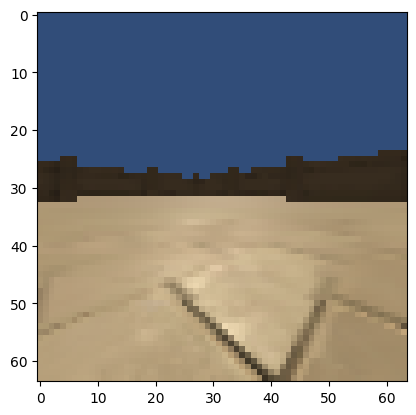

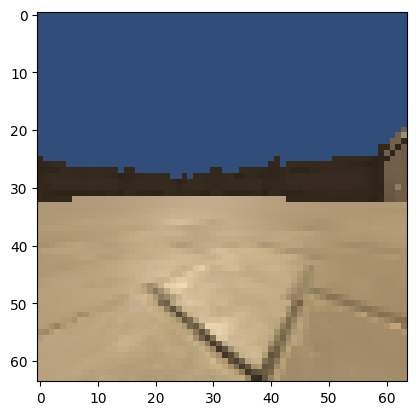

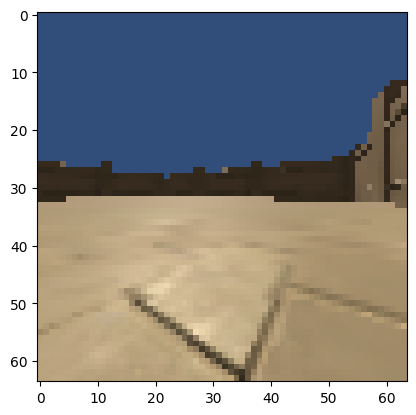

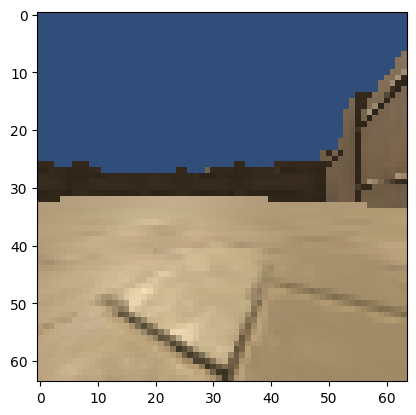

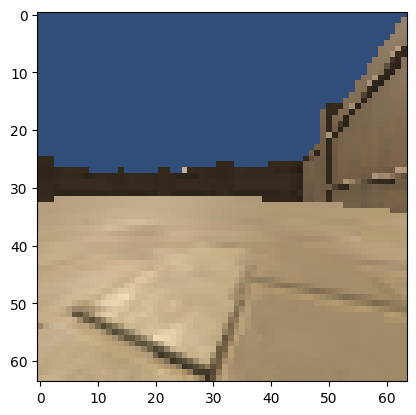

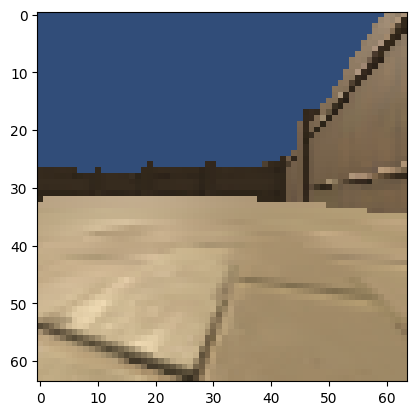

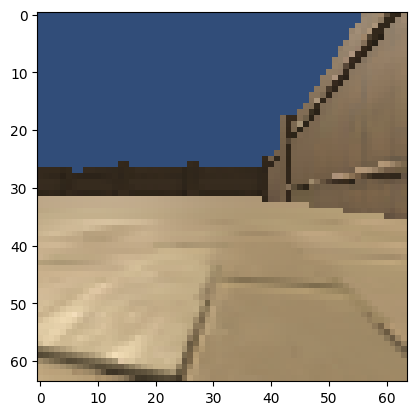

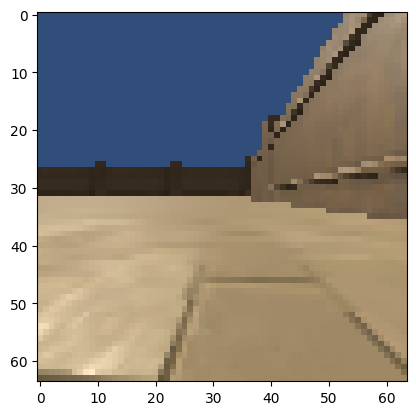

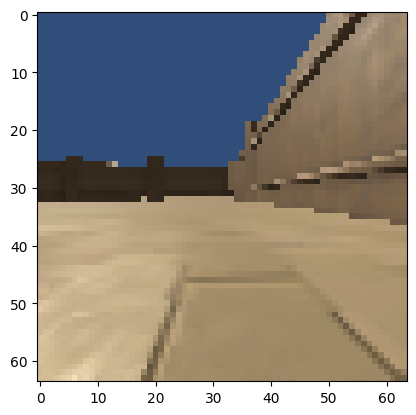

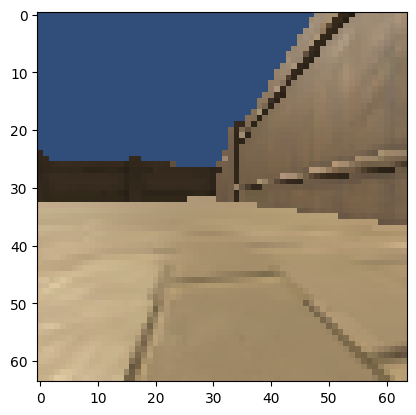

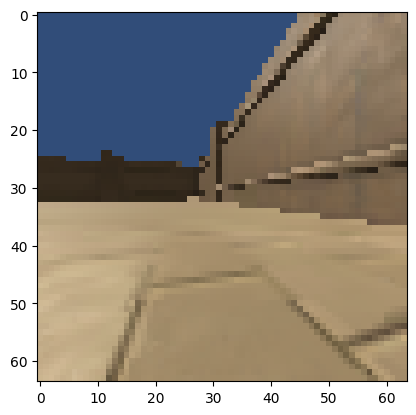

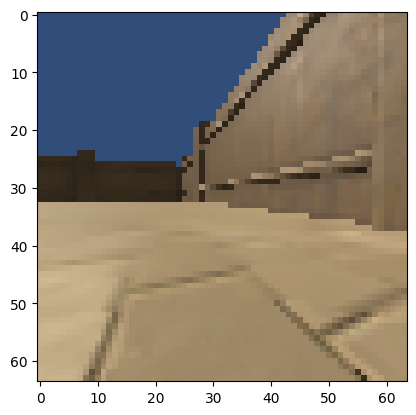

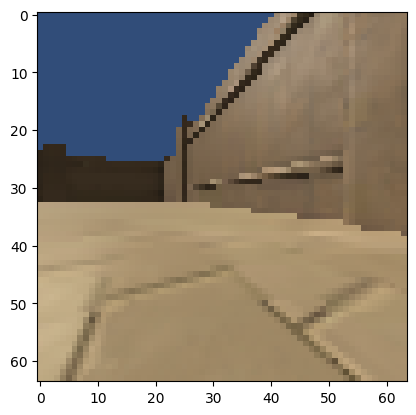

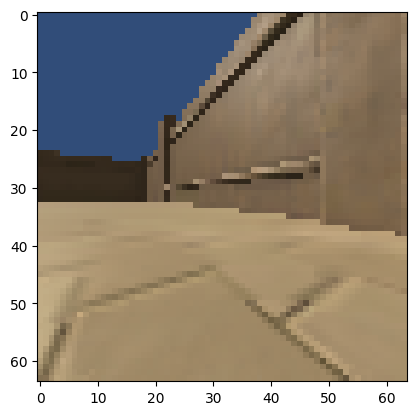

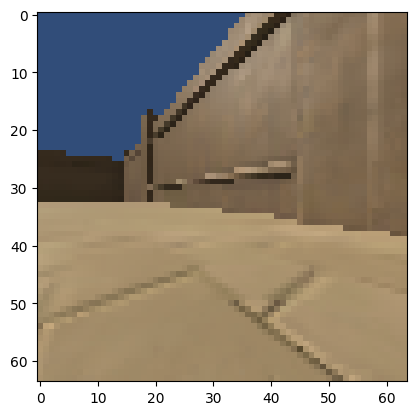

Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}
Array{Float64, 3}


In [50]:
import Random
using Plots, Images, Colors
Random.seed!(4)

# generate trace with specific initial conditions
T = 15
constraints = Gen.choicemap()
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)

py"""
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import display, clear_output
"""

for t=1:T
    py"""
    def display_obs(obs):
        plt.imshow(obs.reshape((resolution, resolution,3)))
        plt.figure()
    """
    py"display_obs"(choices[(:obs, t)])
    println(typeof(choices[(:obs, t)]))
end

In [52]:
function particle_filter(num_particles::Int, obss::Vector{Array{Float64, 3}}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap(((:obs, 1), obss[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    ptot = []
    # steps
    push!(ptot, Gen.sample_unweighted_traces(state, num_samples))
    for t=1:length(obss)-1
        print(t)
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:obs, t), obss[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
        push!(ptot, copy(Gen.sample_unweighted_traces(state, num_samples)))
    end
    
    # return a sample of unweighted traces from the weighted collection
    return ptot
end;

In [53]:

# Generate actual observations
py"""
def gen_obs(cur_node, goal_node,  yaml_data):
    new_yaml_data = set_pose(yaml_data, cur_node)
    new_yaml_data = set_goal_pose(new_yaml_data, goal_node)
    environment.reset(arenas_configurations=new_yaml_data)
    environment.step()
    step_result = environment.get_step_result(agent_group)
    visual_observation = step_result.obs[0]
    print(type(visual_observation))
    return visual_observation
"""
r = 10
x = 20
z = 15
gx = 35
gz = 5
obss = []
for i in 1:T
    vis = py"gen_obs"([x, 0, z, r], [gx, 0, gz],  py"yaml_data")
    cvis = reshape(vis, (size(vis, 2), size(vis, 3), size(vis, 4)) )
    ccvis = convert(Array{Float64, 3}, cvis)
    push!(obss, ccvis) 
    r = (r+6)%360
end

cv_obss = convert( Vector{Array{Float64, 3}}, obss)

@time pf_traces_ot = particle_filter(500, cv_obss, 500);


1234567891011121314540.930439 seconds (8.64 M allocations: 17.227 GiB, 0.23% gc time, 0.01% compilation time)


[30.9621849389117, 29.130776916300817]
[5.057343978282649, 14.659152682796295]
[14.14686476974186, 23.85994452351376]
[2.2048481388344054, 11.971553428138595]
[3.665213284753124, 39.359899896859886]
[38.54485875324461, 4.240892960495675]
[22.763590090132134, 27.932528428933292]
[16.669261424279654, 23.609361511537863]
[29.259906478608386, 39.47059688360035]
[26.87263639415442, 24.395744230171246]
[36.04556324972592, 0.42834243555571305]
[14.14686476974186, 23.85994452351376]
[20.59182575670066, 34.99143238993576]
[34.44778056847797, 31.194384761555945]
[10.022158336386084, 34.59578572260813]
[16.69973916688944, 38.65002524022834]
[18.635550045813012, 9.046451474493491]
[24.35705582116998, 23.92825129395531]
[26.806282664612453, 39.27209388696006]
[2.3969896405070745, 12.947683196353994]
[12.97862102877195, 3.485256679011446]
[24.15800902722891, 12.428155831223107]
[27.83005454433363, 25.459499741167242]
[37.890413532159315, 4.8563731164735024]
[17.406693428512323, 30.748917980970695]
[

[33.63321174859598, 11.537163347443844]
[34.5880419386926, 28.894884623979422]
[37.355568145330984, 39.16749626006779]
[21.743103027119925, 2.518781414712228]
[33.63321174859598, 11.537163347443844]
[6.142270486231691, 14.537032244611234]
[21.28243899592583, 8.5362294880058]
[33.63321174859598, 11.537163347443844]
[14.454108162254169, 28.388248324710048]
[5.942128918175991, 39.98717383611503]
[24.15800902722891, 12.428155831223107]
[17.66777693120588, 26.13077599777715]
[13.42756971118427, 12.967458309012354]
[28.701291477593536, 29.26791237702328]
[6.77425096599098, 22.500947148097623]
[2.8136723043709555, 29.710749579356417]
[14.12018592933296, 28.393787798841778]
[35.81627659722045, 6.900039569686793]
[26.141959938433672, 38.812979749256314]
[19.34373502636862, 19.25917184476524]
[16.14441652104997, 10.036955779695145]
[24.381833627370373, 37.24325688392633]
[7.714760048042741, 32.48234058680555]
[39.48997572461031, 15.365531252672033]
[11.747092703582114, 28.439316370177217]
[14.99

[20.115653986788598, 4.7222501744480905]
[27.52444493496948, 29.443187944085665]
[3.521633416102441, 9.513591739996654]
[3.472169599259205, 15.70883678288392]
[15.286290513201033, 39.05745787124239]
[14.506584171178947, 11.362446910186863]
[24.94429266495893, 13.240398064163648]
[5.700821389551454, 37.230354955869664]
[1.6641729674552508, 12.353581289796622]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.53225485812260

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.532254858122609

[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[0.53225485812260

[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.0587893819

[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.058789381919865]
[0.5322548581226094, 22.911627311340126]
[0.5322548581226094, 22.911627311340126]
[8.193454325408567, 22.0587893819

[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]


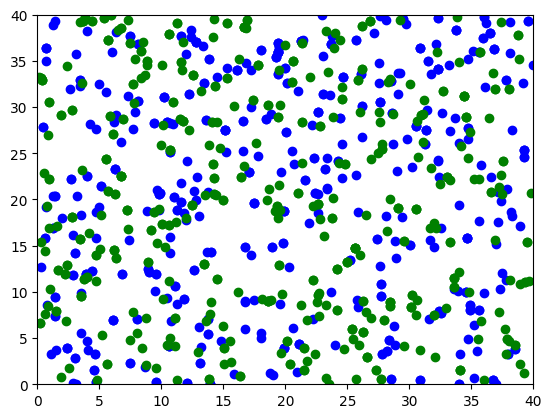

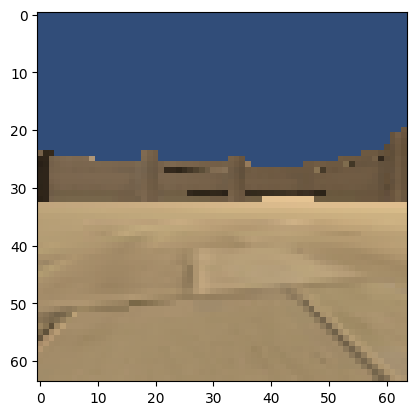

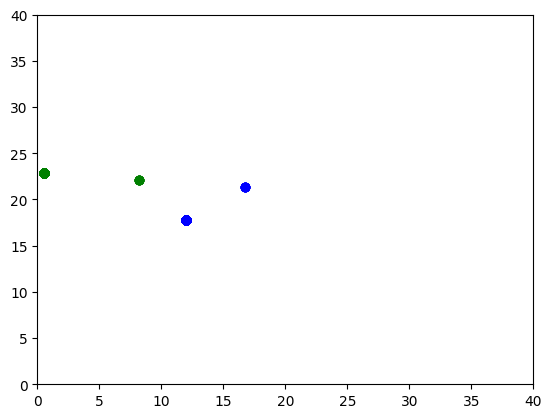

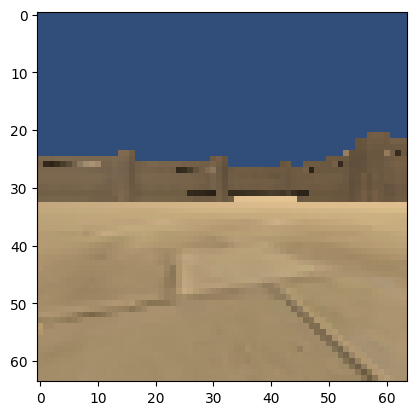

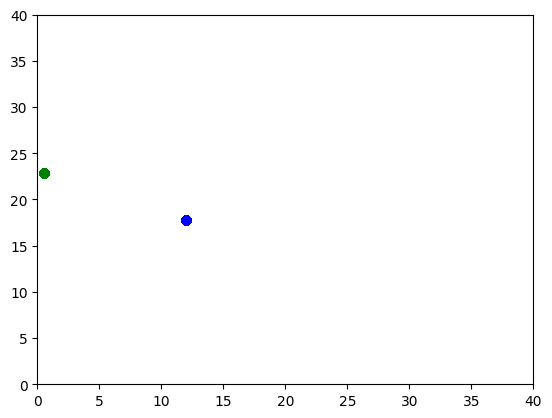

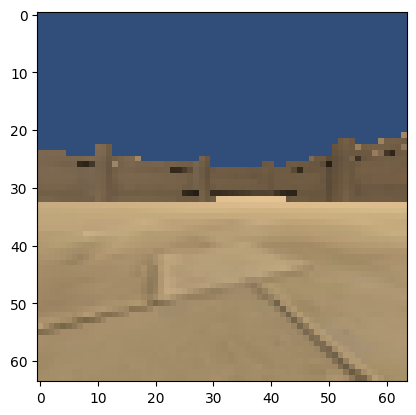

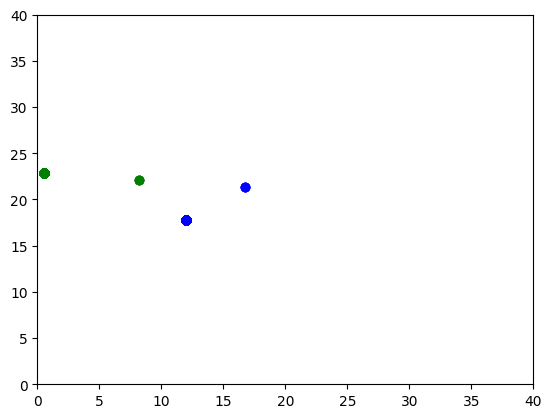

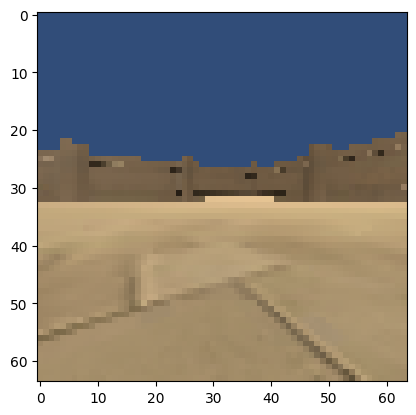

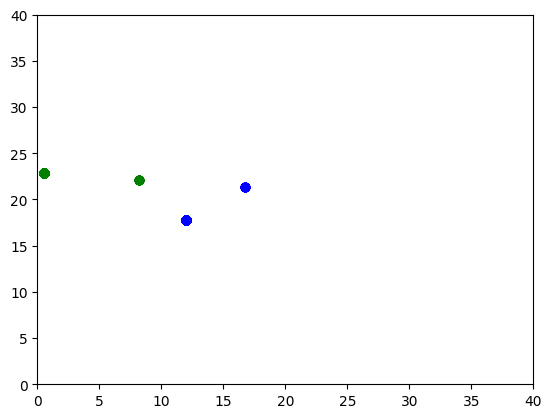

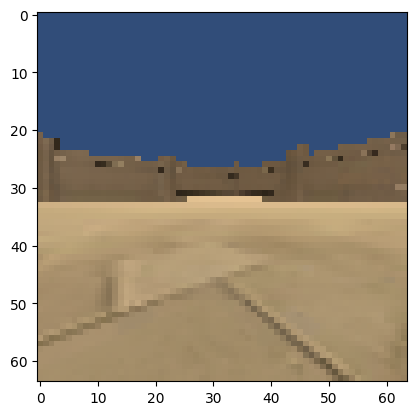

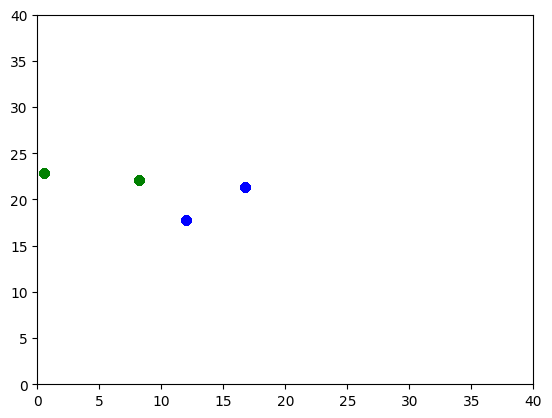

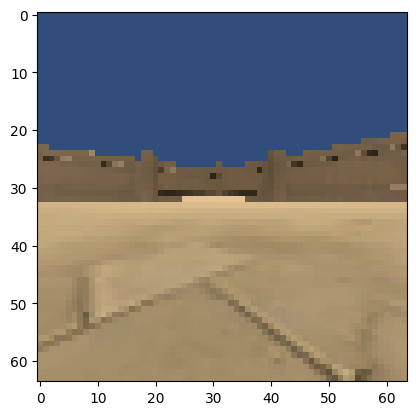

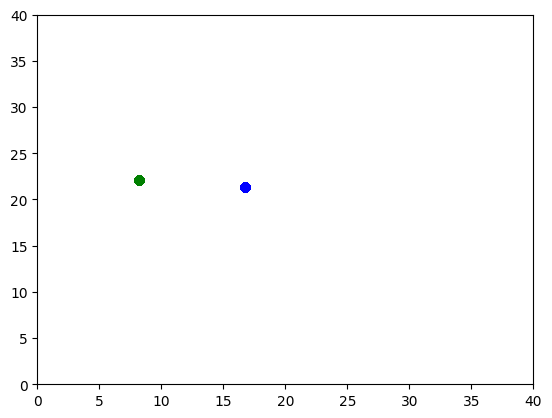

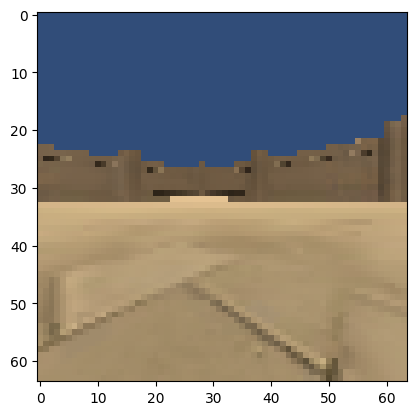

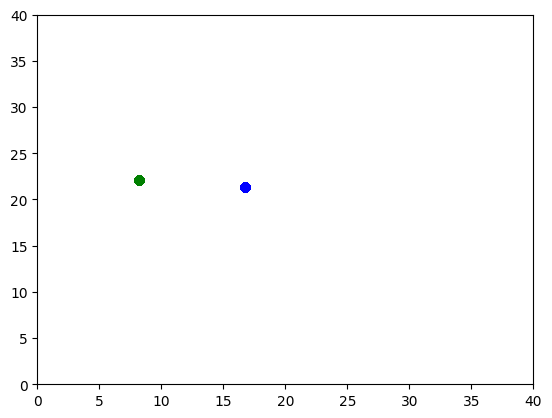

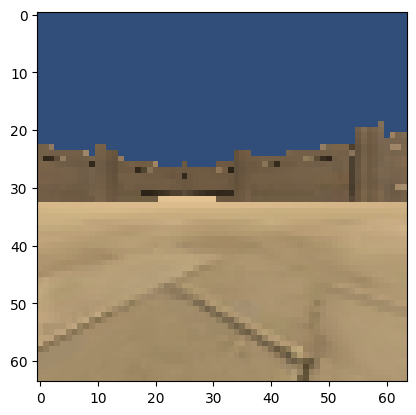

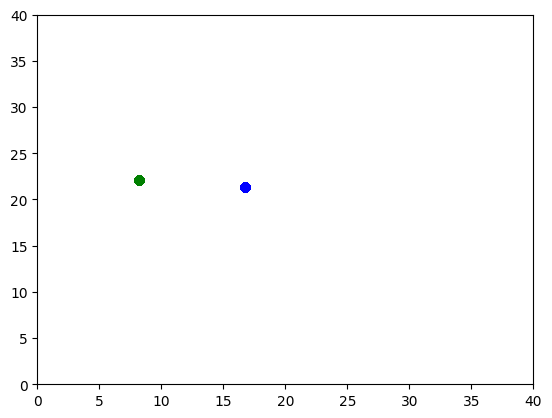

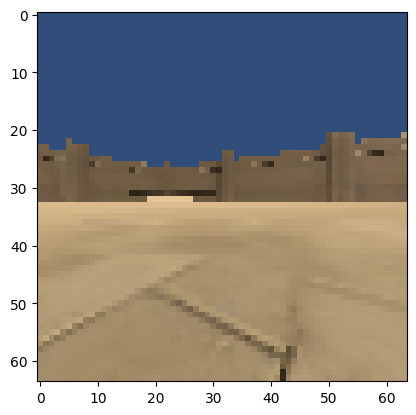

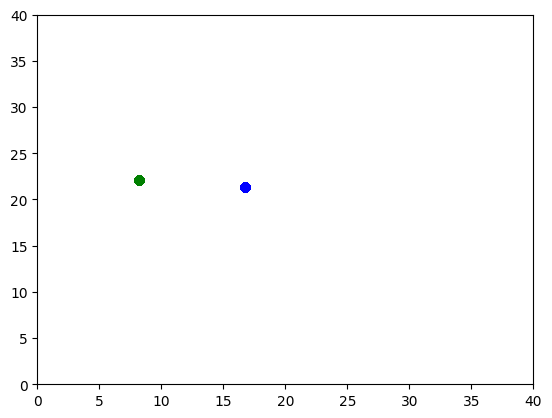

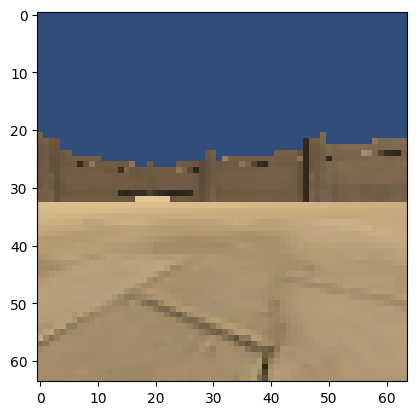

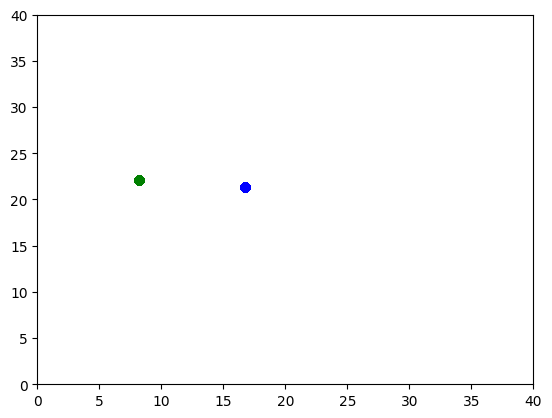

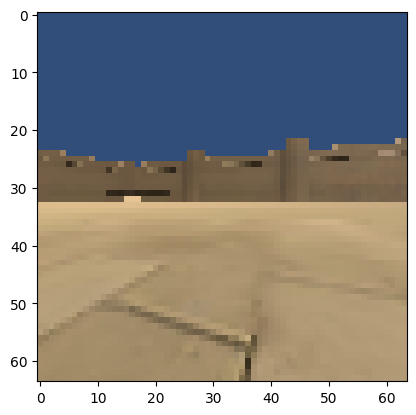

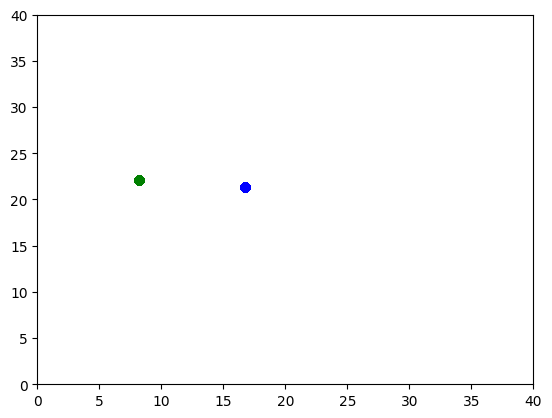

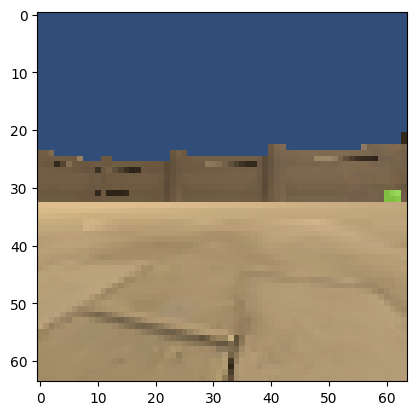

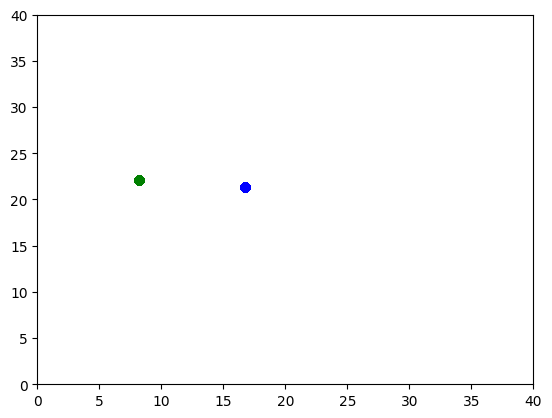

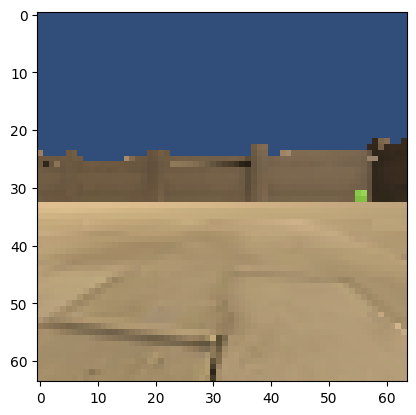

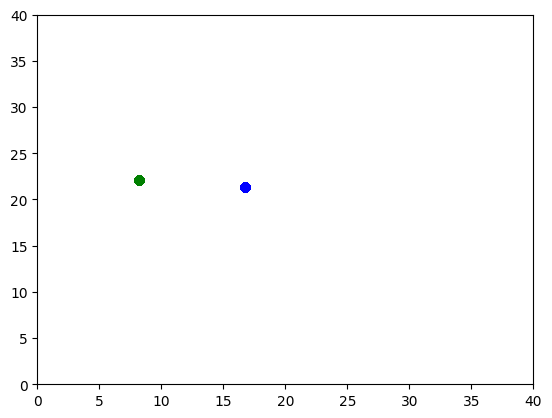

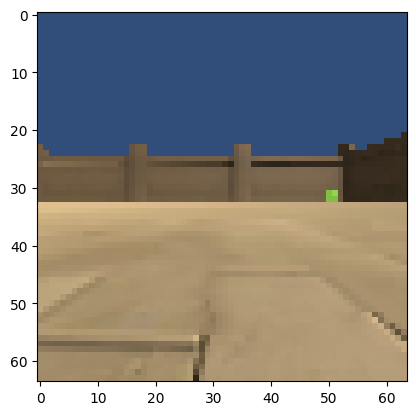

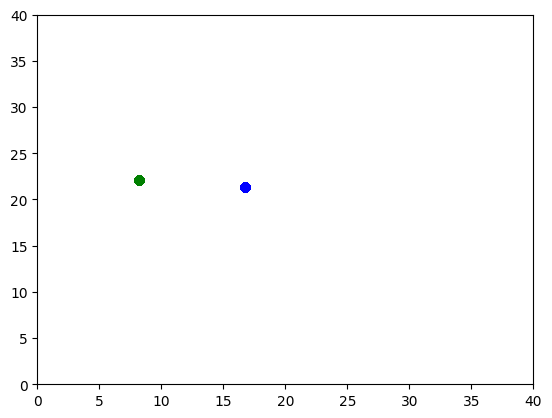

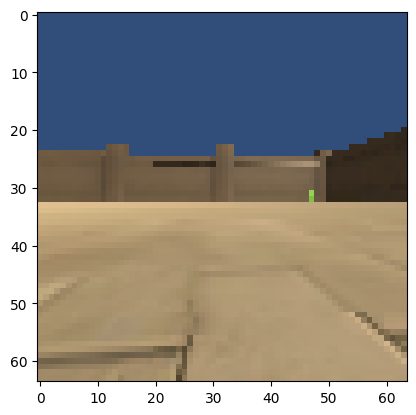

22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 22.058789381919865]
[8.193454325408567, 

In [42]:

for j=1:length(pf_traces_ot)
    points = []
    goals = []
    for i=2:length(pf_traces_ot[j])
        choices = Gen.get_choices(pf_traces_ot[j][i])
        push!(points, [choices[:x0], choices[:z0]])
        push!(goals, [choices[:gx0], choices[:gz0]])
        println([choices[:gx0], choices[:gz0]])
    end
    py"""
    def plot_points(points, color="blue"):
        plt.scatter([point[0] for point in points], [point[1] for point in points], color=color)
        plt.ylim(0, 40)
        plt.xlim(0, 40)
    """
    py"plot_points"(points, color="blue")
    py"plot_points"(goals, color="green")
    py"""plt.figure()"""
    py"display_obs"(cv_obss[j])
    
end


┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg

┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg

┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/args.jl:1238
┌ Warning: linestyle 5 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /Users/aidancurtis/.julia/packages/Plots/lzHOt/src/arg